In [45]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
!pip install pydub

In [47]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
from pydub import AudioSegment

# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

# Used to standardize volume of audio clip
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

# Load raw audio files for speech synthesis
def load_raw_audio(path):
    activates = []
    backgrounds = []
    negatives = []
    for filename in os.listdir(path + "activates"):
        if filename.endswith("wav"):
            activate = AudioSegment.from_wav(path + "activates/" + filename)
            activates.append(activate)
    for filename in os.listdir(path + "backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav(path + "backgrounds/" + filename)
            backgrounds.append(background)
    for filename in os.listdir(path + "negatives"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav(path + "negatives/" + filename)
            negatives.append(negative)
    return activates, negatives, backgrounds

In [48]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython

In [49]:
# Load audio segments using pydub
activates, negatives, backgrounds = load_raw_audio('/content/drive/MyDrive/ML for coders/Deep Learning/Codes/C5/dataset/raw_data/')

print("background len should be 10,000, since it is a 10 sec clip\n" + str(len(backgrounds[0])),"\n")
print("activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) \n" + str(len(activates[0])),"\n")
print("activate[1] len: different `activate` clips can have different lengths\n" + str(len(activates[1])),"\n")

background len should be 10,000, since it is a 10 sec clip
10000 

activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) 
655 

activate[1] len: different `activate` clips can have different lengths
909 



In [50]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [51]:
Ty = 1375 # The number of time steps in the output of our model

In [52]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.

    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")

    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """

    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background
    segment_end = segment_start + segment_ms - 1

    return (segment_start, segment_end)

In [53]:
# UNQ_C1
# GRADED FUNCTION: is_overlapping

def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.

    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments

    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """

    segment_start, segment_end = segment_time

    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False

    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
            break
    ### END CODE HERE ###

    return overlap

In [54]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


In [55]:
# UNQ_C2
# GRADED FUNCTION: insert_audio_clip

def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the
    audio segment does not overlap with existing segments.

    Arguments:
    background -- a 10 second background audio recording.
    audio_clip -- the audio clip to be inserted/overlaid.
    previous_segments -- times where audio segments have already been placed

    Returns:
    new_background -- the updated background audio
    """

    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)

    ### START CODE HERE ###
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)

    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep
    # picking new segment_time at random until it doesn't overlap. To avoid an endless loop
    # we retry 5 times(≈ 2 lines)
    retry = 5
    while is_overlapping(segment_time, previous_segments) and retry >= 0:
        segment_time = get_random_time_segment(segment_ms)
        retry = retry - 1
    ### END CODE HERE ###
        #print(segment_time)
    # if last try is not overlaping, insert it to the background
    if not is_overlapping(segment_time, previous_segments):
    ### START CODE HERE ###
        # Step 3: Append the new segment_time to the list of previous_segments (≈ 1 line)
        previous_segments.append(segment_time)
    ### END CODE HERE ###
        # Step 4: Superpose audio segment and background
        new_background = background.overlay(audio_clip, position = segment_time[0])
    else:
        #print("Timeouted")
        new_background = background
        segment_time = (10000, 10000)

    return new_background, segment_time

In [56]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(backgrounds[0], activates[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

Output hidden; open in https://colab.research.google.com to view.

In [57]:
# UNQ_C3
# GRADED FUNCTION: insert_ones

def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 following labels should be ones.


    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms

    Returns:
    y -- updated labels
    """
    _, Ty = y.shape

    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)

    if segment_end_y < Ty:
        # Add 1 to the correct index in the background label (y)
        ### START CODE HERE ### (≈ 3 lines)
        for i in range(segment_end_y+1, segment_end_y+51):
            if i < Ty:
                y[0, i] = 1
        ### END CODE HERE ###

    return y

sanity checks: 0.0 1.0 0.0


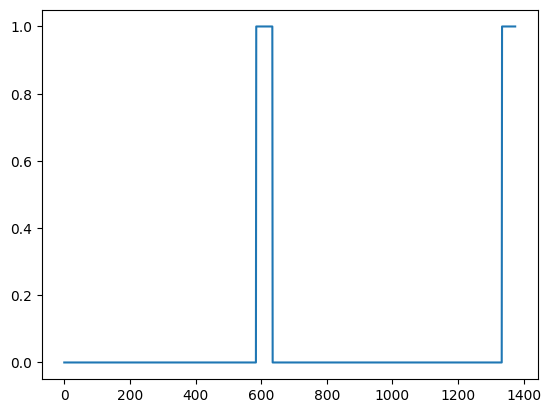

In [58]:
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

In [59]:
def create_training_example(background, activates, negatives, Ty):
    """
    Creates a training example with a given background, activates, and negatives.

    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    Ty -- The number of time steps in the output

    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """

    # Make background quieter
    background = background - 20

    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1,Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###

    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]

    ### START CODE HERE ### (≈ 3 lines)
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for one_random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, one_random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y" at segment_end
        y = insert_ones(y, segment_end)
    ### END CODE HERE ###

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    ### START CODE HERE ### (≈ 2 lines)
    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    ### END CODE HERE ###

    # Standardize the volume of the audio clip
    background = match_target_amplitude(background, -20.0)

    # Export new training example
    file_handle = background.export("train" + ".wav", format="wav")

    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")

    return x, y

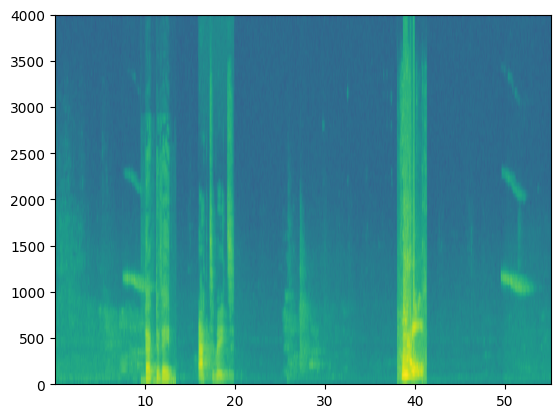

In [60]:
# Set the random seed
np.random.seed(18)
x, y = create_training_example(backgrounds[0], activates, negatives, Ty)

0
10
20
30


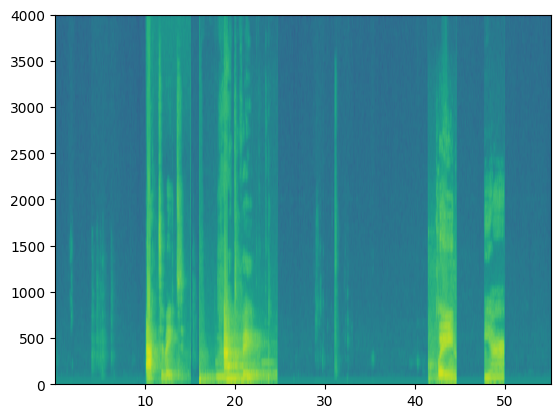

In [61]:
np.random.seed(4543)
nsamples = 32
X = []
Y = []
for i in range(0, nsamples):
    if i%10 == 0:
        print(i)
    x, y = create_training_example(backgrounds[i % 2], activates, negatives, Ty)
    X.append(x.swapaxes(0,1))
    Y.append(y.swapaxes(0,1))
X = np.array(X)
Y = np.array(Y)

In [62]:
X_dev = np.load("/content/drive/MyDrive/ML for coders/Deep Learning/Codes/C5/dataset/XY_dev/X_dev.npy")
Y_dev = np.load("/content/drive/MyDrive/ML for coders/Deep Learning/Codes/C5/dataset/XY_dev/Y_dev.npy")

In [63]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam


In [64]:
# UNQ_C5
# GRADED FUNCTION: modelf

def modelf(input_shape):
    """
    Function creating the model's graph in Keras.

    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """

    X_input = Input(shape = input_shape)

    ### START CODE HERE ###

    # Step 1: CONV layer (≈4 lines)
    # Add a Conv1D with 196 units, kernel size of 15 and stride of 4
    X = Conv1D(filters=196,kernel_size=15,strides=4)(X_input)
    # Batch normalization
    X = BatchNormalization()(X)
    # ReLu activation
    X = Activation("relu")(X)
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X)
    # Step 2: First GRU Layer (≈4 lines)
    # GRU (use 128 units and return the sequences)
    X = GRU(units=128, return_sequences = True)(X)
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X)
    # Batch normalization.
    X = BatchNormalization()(X)

    # Step 3: Second GRU Layer (≈4 lines)
    # GRU (use 128 units and return the sequences)
    X = GRU(units=128, return_sequences = True)(X)
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X)
    # Batch normalization
    X = BatchNormalization()(X)
    # dropout (use 0.8)
    X = Dropout(rate=0.8)(X)

    # Step 4: Time-distributed dense layer (≈1 line)
    # TimeDistributed  with sigmoid activation
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)

    return model

In [65]:
model = modelf(input_shape = (Tx, n_freq))

In [66]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5511, 101)]       0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1375, 196)         297136    
                                                                 
 batch_normalization_3 (Bat  (None, 1375, 196)         784       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 1375, 196)         0         
                                                                 
 dropout_4 (Dropout)         (None, 1375, 196)         0         
                                                                 
 gru_2 (GRU)                 (None, 1375, 128)         125184    
                                                           

In [67]:
from tensorflow.keras.models import model_from_json

json_file = open('/content/drive/MyDrive/ML for coders/Deep Learning/Codes/C5/dataset/models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('/content/drive/MyDrive/ML for coders/Deep Learning/Codes/C5/dataset/models/model.h5')

In [68]:
model.layers[2].trainable = False
model.layers[7].trainable = False
model.layers[10].trainable = False


In [69]:
opt = Adam(lr=1e-6, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [70]:
model.fit(X, Y, batch_size = 16, epochs=1)

2/2 [==============================] - 18s 9s/step - loss: 0.5823 - accuracy: 0.7408


In [71]:
loss, acc, = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

1/1 [==============================] - 7s 7s/step - loss: 0.3549 - accuracy: 0.9235
Dev set accuracy =  0.9235491156578064


In [72]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    # Correct the amplitude of the input file before prediction
    audio_clip = AudioSegment.from_wav(filename)
    audio_clip = match_target_amplitude(audio_clip, -20.0)
    file_handle = audio_clip.export("tmp.wav", format="wav")
    filename = "tmp.wav"

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)

    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions